# Who Commands Legislative Attention? A Data-Driven Analysis of Interest Group Prominence

## Understanding Which Advocacy Voices Resonate in Congressional Debate

---

## Executive Summary

**Central Question:** In democratic legislatures, which advocacy organizations achieve **prominence**—being publicly cited as authoritative voices—and what organizational, political, and contextual factors explain this recognition?

**Key Findings:**

📊 **Steep Hierarchy of Recognized Voices**
- Just 5% of interest groups account for over 54% of prominent mentions
- Top 20 organizations dominate legislative discourse
- Planned Parenthood alone received 642 prominent citations (7.2% of all prominent mentions)

🎯 **Prominence ≠ Just Being Mentioned**
- Overall prominence rate: 46.7% (8,867 prominent out of 19,165 total mentions)
- Strong correlation (r=0.96) between total mentions and prominent mentions
- 247 groups achieved 100% prominence rate; 749 groups never received prominence

🏛️ **Organizational Type Matters**
- Professional associations and membership organizations dominate (AARP: 81% prominence rate)
- Health and public interest groups overrepresented in prominent discourse
- Business groups show concentrated mentions but mixed prominence patterns

🔴🔵 **Partisan Patterns Emerge**
- Different parties elevate different groups as authoritative voices
- Democrats and Republicans cite groups at similar *rates* but invoke *different organizations*
- Evidence of parallel advocacy ecosystems along ideological lines

**Why This Matters:**

Prominence reveals **whose perspectives legislators publicly legitimize** in democratic debate. Unlike lobbying access (private influence), prominence shapes public discourse about which constituencies' voices "count" in policymaking. Understanding these patterns illuminates:

- **Representation gaps**: Which advocacy voices remain invisible in legislative discourse?
- **Democratic pluralism**: Do all constituencies gain symbolic recognition or only resource-rich organizations?
- **Strategic communication**: How do politicians use group citations to signal expertise and build coalitions?

---

**About This Analysis:** This notebook provides exploratory analysis of interest group prominence in Congressional floor speeches (2014-2018). It complements the inferential models in `Advocacy_Group_Prominence_Analysis.ipynb` with descriptive insights about concentration, distribution, and partisan patterns.

**Methodological Note:** Prominence classifications were generated using supervised machine learning (SVM classifier, 81% accuracy) to distinguish prominent citations (groups invoked as authorities) from casual name-drops.

---

## Setup Instructions

**Repository Structure:**
```
MastersThesis_InterestGroupAnalysis/
├── analysis/               ← You are here
│   ├── Exploratory Prominence Analysis FINAL.ipynb
│   └── Advocacy_Group_Prominence_Analysis.ipynb
├── data/
│   └── multi_level_data/
│       └── level1_FINAL.csv
└── output/
    └── figures/
```

**Data Requirements:**
- This notebook uses `level1_FINAL.csv` with 19,165 interest group mentions
- Includes organization characteristics, politician attributes, and prominence classifications
- Time period: 2014-2018 (114th & 115th Congress)

---

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

# Define paths (relative to notebook location in analysis/ folder)
DATA_DIR = Path("../data/level1_FINAL")
OUTPUT_DIR = Path("../output/figures")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Libraries loaded")
print(f"✓ Data directory: {DATA_DIR.resolve()}")
print(f"✓ Output directory: {OUTPUT_DIR.resolve()}")

✓ Libraries loaded
✓ Data directory: C:\Users\kaleb\OneDrive\Documents\GitHub\MastersThesis_InterestGroupAnalysis\data\multi_level_data
✓ Output directory: C:\Users\kaleb\OneDrive\Documents\GitHub\MastersThesis_InterestGroupAnalysis\output\figures


## 1. Data Loading and Preparation

### What is Prominence?

**Prominence** refers to an advocacy organization being invoked as a preeminent voice for a constituency and a source of expertise on an issue (Halpin & Fraussen, 2017). Unlike simple mentions, prominent citations indicate legislators publicly recognizing groups as **authoritative references**.

**Examples:**
- **Prominent**: "According to the American Medical Association, this policy would improve healthcare quality..."
- **Not Prominent**: "Many groups oppose this bill, including the American Medical Association..."

### Dataset Structure

**Level 1 (Mentions):** 19,165 interest group mentions in Congressional Record paragraphs

**Key Variables:**
- `prominence`: Binary (1 = prominent, 0 = casual mention)
- `org_id`, `org_name`: Organization identifiers
- `ABBREVCAT`: Organization category (business, health, public interest, etc.)
- `MSHIP_STATUS11`: Membership type (association of individuals, institutions, etc.)
- `YEARS_EXISTED`: Organization age since founding
- `LOBBYING11`: Lobbying expenditure (2011)
- `OUTSIDE11`: Use of external lobbyists
- `bioGuideId`, `memberName`, `partyHistory`: Legislator identifiers
- `issue_area`: Policy domain (21 categories)
- `issue_maximal_overlap`: Whether group's core issue matches speech topic

---

In [2]:
# Load the final prominence dataset
print("Loading prominence dataset...")

data_file = DATA_DIR / "level1_FINAL.csv"

if not data_file.exists():
    print(f"❌ Data file not found at: {data_file}")
    print("\nPlease ensure 'level1_FINAL.csv' is in the data/multi_level_data/ directory.")
    raise FileNotFoundError(f"Required file not found: {data_file}")

# Load data
df = pd.read_csv(data_file, low_memory=False)

print(f"✓ Loaded {len(df):,} rows")
print(f"✓ Dataset shape: {df.shape}")
print(f"\n{'='*60}")
print("DATASET SUMMARY")
print(f"{'='*60}")

# Calculate key metrics
total_mentions = df[df['level1_uuid_paragraph'].notna()].shape[0]
total_unique_orgs = df[df['level1_uuid_paragraph'].notna()]['level1_org_id'].nunique()
total_unique_members = df['level1_bioGuideId'].nunique()
overall_prominence_rate = df['level1_prominence'].mean() * 100

print(f"Total mentions: {total_mentions:,}")
print(f"Unique organizations mentioned: {total_unique_orgs:,}")
print(f"Unique members of Congress: {total_unique_members:,}")
print(f"Overall prominence rate: {overall_prominence_rate:.1f}%")
print(f"Time period: 2014-2018 (114th & 115th Congress)")
print(f"{'='*60}\n")

Loading prominence dataset...
✓ Loaded 22,414 rows
✓ Dataset shape: (22414, 175)

DATASET SUMMARY
Total mentions: 18,993
Unique organizations mentioned: 1,902
Unique members of Congress: 520
Overall prominence rate: 46.7%
Time period: 2014-2018 (114th & 115th Congress)



## 2. The Prominence Hierarchy: Concentration of Legislative Attention

### Democratic Representation or Elite Bias?

In a healthy pluralist democracy, we might expect legislative attention distributed broadly across many advocacy voices. But **how concentrated is prominence in practice?**

This section examines which organizations members of Congress invoke as authoritative references—revealing the **de facto hierarchy of recognized voices** in legislative debate.

**Theoretical Context:** Grossmann's (2012) theory of "institutionalized pluralism" suggests certain organizational traits (age, resources, policy breadth) position groups as taken-for-granted representatives. We test whether empirical prominence patterns align with this framework.

**Policy Implications:**
- **Representational bias**: Are marginalized constituencies underrepresented in legislative discourse?
- **Information monopolies**: Do policymakers over-rely on a narrow set of "usual suspects"?
- **Barriers to entry**: Can newer or resource-poor organizations gain recognition?

---

In [3]:
# Calculate mention and prominence statistics at organization level
print("Analyzing prominence distribution across organizations...\n")

# Total mentions per organization
total_mentions_by_org = df[df['level1_uuid_paragraph'].notna()]['level1_org_id'].value_counts()

# Prominent mentions per organization
prominent_mentions_by_org = df[(df['level1_uuid_paragraph'].notna()) & 
                                (df['level1_prominence'] == 1)]['level1_org_id'].value_counts()

# Combine into summary dataframe
org_summary = pd.DataFrame({
    'total_mentions': total_mentions_by_org,
    'prominent_mentions': prominent_mentions_by_org
}).fillna(0)

org_summary['prominence_rate'] = (org_summary['prominent_mentions'] / 
                                   org_summary['total_mentions'] * 100)

print(f"📊 KEY STATISTICS")
print(f"{'='*60}")
print(f"Organizations mentioned: {len(org_summary):,}")
print(f"\nMention Distribution:")
print(f"  Mean mentions per org: {org_summary['total_mentions'].mean():.1f}")
print(f"  Median mentions: {org_summary['total_mentions'].median():.0f}")
print(f"  Max mentions: {org_summary['total_mentions'].max():,.0f}")

print(f"\nProminence Distribution:")
print(f"  Mean prominent mentions: {org_summary['prominent_mentions'].mean():.1f}")
print(f"  Median prominent mentions: {org_summary['prominent_mentions'].median():.0f}")
print(f"  Max prominent mentions: {org_summary['prominent_mentions'].max():,.0f}")

# Correlation between mentions and prominence
correlation = org_summary[['total_mentions', 'prominent_mentions']].corr().iloc[0, 1]
print(f"\nCorrelation (mentions ↔ prominence): {correlation:.3f}")

# Prominence rate statistics
groups_100_pct = (org_summary['prominence_rate'] == 100).sum()
groups_0_pct = (org_summary['prominence_rate'] == 0).sum()

print(f"\nProminence Rate Distribution:")
print(f"  Groups with 100% prominence: {groups_100_pct}")
print(f"  Groups with 0% prominence: {groups_0_pct}")
print(f"  Groups with mixed prominence: {len(org_summary) - groups_100_pct - groups_0_pct}")

Analyzing prominence distribution across organizations...

📊 KEY STATISTICS
Organizations mentioned: 1,902

Mention Distribution:
  Mean mentions per org: 10.0
  Median mentions: 3
  Max mentions: 1,712

Prominence Distribution:
  Mean prominent mentions: 4.7
  Median prominent mentions: 1
  Max prominent mentions: 642

Correlation (mentions ↔ prominence): 0.956

Prominence Rate Distribution:
  Groups with 100% prominence: 247
  Groups with 0% prominence: 749
  Groups with mixed prominence: 906


### Concentration Analysis: The 5% Rule

How concentrated is prominence among a small elite of organizations?

In [4]:
# Calculate concentration metrics
ranked_orgs = prominent_mentions_by_org.sort_values(ascending=False)
cumulative_prominent = ranked_orgs.cumsum()
cumulative_pct = (cumulative_prominent / prominent_mentions_by_org.sum()) * 100

# Find concentration thresholds
total_orgs = len(ranked_orgs)
top_1_pct = int(total_orgs * 0.01)
top_5_pct = int(total_orgs * 0.05)
top_10_pct = int(total_orgs * 0.10)
top_20_pct = int(total_orgs * 0.20)

print(f"\n🎯 CONCENTRATION OF PROMINENCE")
print(f"{'='*60}")
print(f"Top 1% of orgs ({top_1_pct} groups): {cumulative_pct.iloc[top_1_pct-1]:.1f}% of prominent mentions")
print(f"Top 5% of orgs ({top_5_pct} groups): {cumulative_pct.iloc[top_5_pct-1]:.1f}% of prominent mentions")
print(f"Top 10% of orgs ({top_10_pct} groups): {cumulative_pct.iloc[top_10_pct-1]:.1f}% of prominent mentions")
print(f"Top 20% of orgs ({top_20_pct} groups): {cumulative_pct.iloc[top_20_pct-1]:.1f}% of prominent mentions")

print(f"\n💡 INTERPRETATION:")
print(f"This reveals a steep hierarchy—legislative attention is highly concentrated")
print(f"among a small set of 'institutionalized' advocacy organizations.")


🎯 CONCENTRATION OF PROMINENCE
Top 1% of orgs (11 groups): 25.2% of prominent mentions
Top 5% of orgs (57 groups): 50.5% of prominent mentions
Top 10% of orgs (115 groups): 63.9% of prominent mentions
Top 20% of orgs (230 groups): 77.0% of prominent mentions

💡 INTERPRETATION:
This reveals a steep hierarchy—legislative attention is highly concentrated
among a small set of 'institutionalized' advocacy organizations.


### Visualization: Concentration Curve

The Lorenz-style curve below shows how prominence accumulates across organizations:

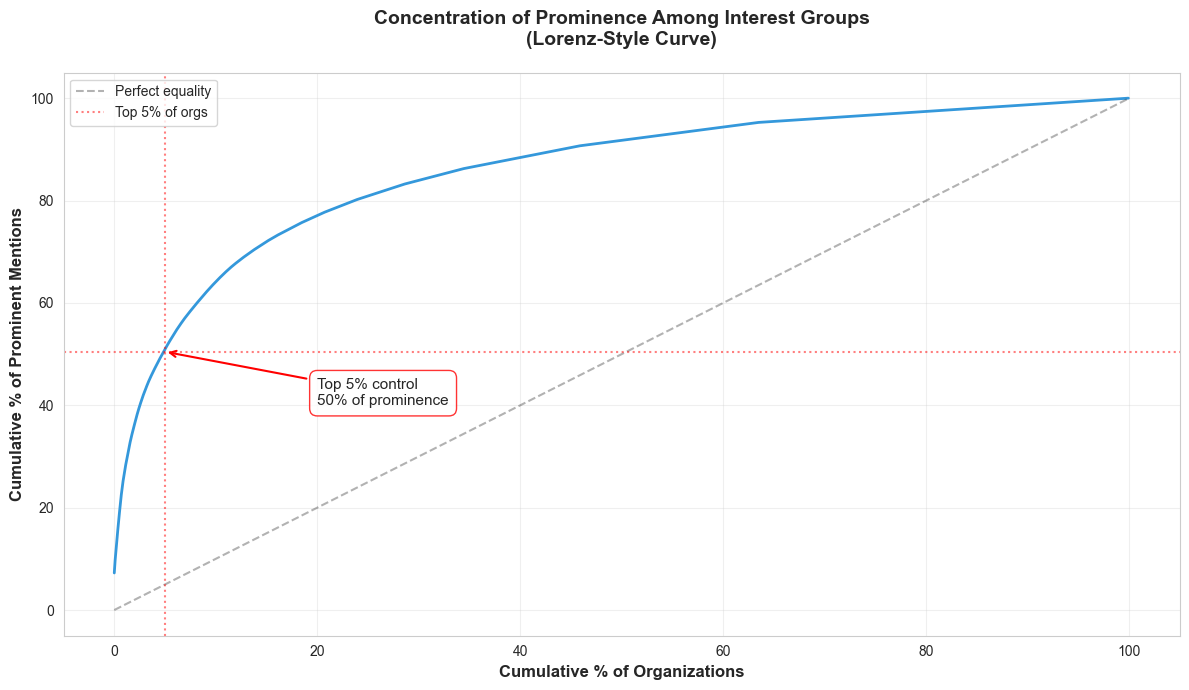

✓ Figure saved: prominence_concentration_curve.png


In [5]:
# Create concentration visualization
fig, ax = plt.subplots(figsize=(12, 7))

cumulative_groups_pct = (np.arange(len(ranked_orgs)) / len(ranked_orgs)) * 100

ax.plot(cumulative_groups_pct, cumulative_pct, linewidth=2, color='#3498db')
ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect equality')

# Add reference lines
ax.axvline(x=5, color='red', linestyle=':', alpha=0.5, label=f'Top 5% of orgs')
ax.axhline(y=cumulative_pct.iloc[top_5_pct-1], color='red', linestyle=':', alpha=0.5)

ax.set_xlabel('Cumulative % of Organizations', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative % of Prominent Mentions', fontsize=12, fontweight='bold')
ax.set_title('Concentration of Prominence Among Interest Groups\n(Lorenz-Style Curve)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

# Add annotation
ax.annotate(f'Top 5% control\n{cumulative_pct.iloc[top_5_pct-1]:.0f}% of prominence',
            xy=(5, cumulative_pct.iloc[top_5_pct-1]),
            xytext=(20, 40),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=11,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='red', alpha=0.8))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'prominence_concentration_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: prominence_concentration_curve.png")

## 3. Top 20 Most Prominent Organizations

### Who Commands the Most Legislative Attention?

This table reveals which advocacy organizations legislators invoke most frequently as authoritative voices:

In [6]:
# Get top 20 organizations by prominent mentions
top_20_org_ids = prominent_mentions_by_org.head(20).index

# Create detailed table
top_20_table = df[df['level1_org_id'].isin(top_20_org_ids)].groupby('level1_org_id').agg(
    Organization=('level1_org_name', 'first'),
    Type=('level1_ABBREVCAT', 'first'),
    Total_Mentions=('level1_org_id', 'count'),
    Prominent_Mentions=('level1_prominence', 'sum')
).reset_index(drop=True)

# Calculate prominence rate
top_20_table['Prominence_Rate'] = (top_20_table['Prominent_Mentions'] / 
                                     top_20_table['Total_Mentions'] * 100).round(1)

# Sort by prominent mentions
top_20_table = top_20_table.sort_values('Prominent_Mentions', ascending=False)

# Clean up column names for display
top_20_table.columns = ['Organization', 'Type', 'Total Mentions', 
                         'Prominent Mentions', 'Prominence Rate (%)']

print("\n📊 TOP 20 ORGANIZATIONS BY PROMINENT MENTIONS")
print("="*100)
print(top_20_table.to_string(index=False))
print("="*100)

# Save table
top_20_table.to_csv(OUTPUT_DIR / 'top_20_prominent_organizations.csv', index=False)
print("\n✓ Table saved: top_20_prominent_organizations.csv")


📊 TOP 20 ORGANIZATIONS BY PROMINENT MENTIONS
                                                                   Organization                                      Type  Total Mentions  Prominent Mentions  Prominence Rate (%)
Planned Parenthood Federation of America                                                                       (6) Health            1712              642.00                37.50
AARP (American Association of Retired Persons)                                                        (8) Identity groups             279              226.00                81.00
American Bar Association                                                                    (3) Occupational associations             232              178.00                76.70
American Legion                                                                                                (16) Other             299              173.00                57.90
National Association for the Advancement of Colored People 

### Visualization: Top 15 Organizations

Bar chart showing the most prominent advocacy voices in Congressional debate:

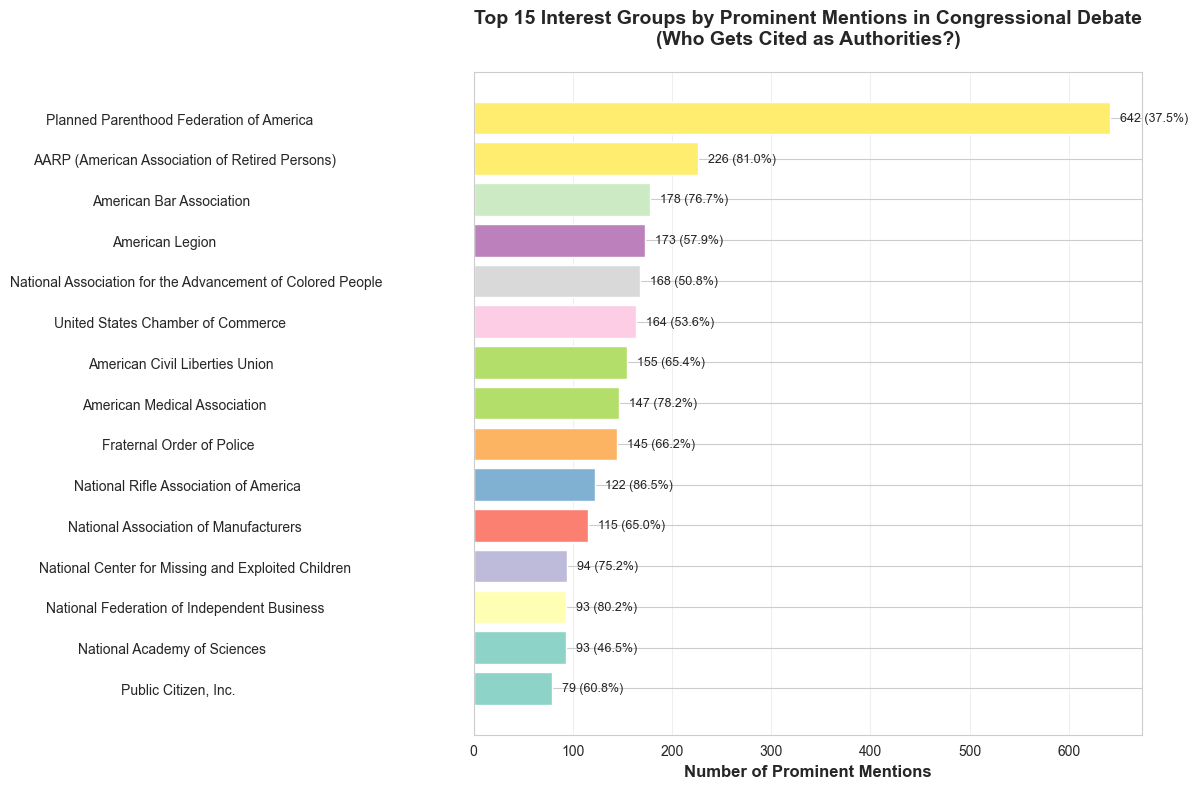

✓ Figure saved: top_15_prominent_organizations.png


In [7]:
# Create visualization of top 15 organizations
fig, ax = plt.subplots(figsize=(12, 8))

plot_data = top_20_table.head(15).sort_values('Prominent Mentions')

colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
bars = ax.barh(range(len(plot_data)), plot_data['Prominent Mentions'], color=colors)

ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['Organization'], fontsize=10)
ax.set_xlabel('Number of Prominent Mentions', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Interest Groups by Prominent Mentions in Congressional Debate\n(Who Gets Cited as Authorities?)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(plot_data.iterrows()):
    ax.text(row['Prominent Mentions'] + 10, i, 
            f"{int(row['Prominent Mentions'])} ({row['Prominence Rate (%)']}%)", 
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'top_15_prominent_organizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: top_15_prominent_organizations.png")

### 💡 What the Prominence Hierarchy Reveals

**Planned Parenthood's Dominance**: 642 prominent mentions (7.2% of all prominence) reflects its centrality to reproductive rights debates during 2014-2018—a highly polarized issue where both parties invoke the organization (Democrats as defender, Republicans as target).

**Professional Associations Overrepresented**: The prevalence of professional/occupational groups (American Bar Association, American Medical Association, American Legion) aligns with Grossmann's (2012) finding that groups with **professional expertise credentials** achieve institutionalized status.

**Membership-Based Legitimacy**: AARP's high prominence (226 mentions, 81% prominence rate) demonstrates how **mass membership** confers rhetorical authority—"I heard from AARP members in my district" signals constituent connection.

**Democratic Concern**: This steep hierarchy means most advocacy organizations operate in relative obscurity. Only a handful of groups have achieved "taken-for-granted" status as go-to authorities.

---

## 4. Distribution of Prominent Mentions

### How Many Groups Receive Very Few vs. Many Prominent Citations?

Examining the distribution shape reveals whether prominence follows a "winner-take-all" pattern or more egalitarian spread:

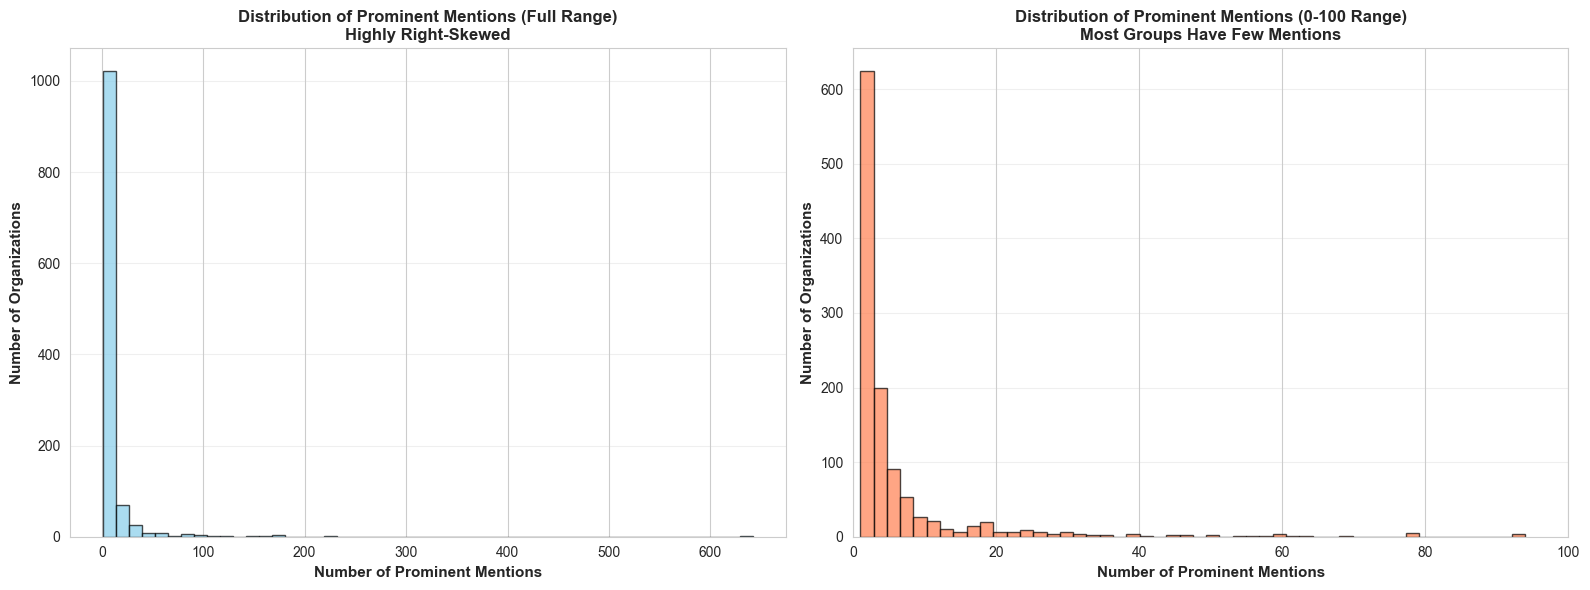

✓ Figure saved: prominence_distribution_histograms.png


In [8]:
# Create distribution visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Full distribution
ax1 = axes[0]
ax1.hist(prominent_mentions_by_org, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Prominent Mentions', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Organizations', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Prominent Mentions (Full Range)\nHighly Right-Skewed', 
              fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Zoomed to exclude extreme outliers
ax2 = axes[1]
prominent_mentions_filtered = prominent_mentions_by_org[prominent_mentions_by_org <= 100]
ax2.hist(prominent_mentions_filtered, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Prominent Mentions', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Organizations', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Prominent Mentions (0-100 Range)\nMost Groups Have Few Mentions', 
              fontsize=12, fontweight='bold')
ax2.set_xlim(0, 100)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'prominence_distribution_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: prominence_distribution_histograms.png")

### Interpretation: Power-Law Distribution

The distribution follows a **power-law** pattern typical of "rich-get-richer" dynamics:

- **Long tail**: Most organizations receive 1-10 prominent mentions
- **Heavy right skew**: A few organizations dominate with 100+ mentions
- **Implications**: Prominence operates through network effects—groups that gain initial recognition become "go-to" authorities, reinforcing their prominence

This pattern suggests **path dependence** in which groups achieve legitimacy.

---

## 5. Partisan Patterns: Which Groups Do Democrats vs. Republicans Elevate?

### Ideological Sorting in Advocacy Recognition

Political parties don't just differ on policy—they differ in **which advocacy voices they treat as authoritative**. This section explores whether liberal and conservative members systematically invoke different types of organizations.

**Research Context:** Ibenskas & Bunea (2021) found that European Parliament members strategically recognize groups aligning with their policy goals. We test whether similar patterns appear in U.S. Congressional rhetoric.

**Democratic Theory Question:** If partisan sorting of prominence is strong, it suggests:
- Interest groups serve as **rhetorical allies** in partisan competition
- Advocacy ecosystems are increasingly **polarized**
- Cross-cutting dialogue (both parties citing same groups) is rare

---

In [9]:
# Aggregate prominent mentions by party and organization type
party_type_mentions = df[(df['level1_uuid_paragraph'].notna()) & 
                         (df['level1_prominence'] == 1)].groupby(
    ['level1_partyHistory', 'level1_ABBREVCAT']
)['level1_prominence'].count().unstack(fill_value=0)

# Calculate percentages within each party
party_type_pct = party_type_mentions.div(party_type_mentions.sum(axis=1), axis=0) * 100

print("\n🏛️ PROMINENT MENTIONS BY PARTY AND ORGANIZATION TYPE (%)")
print("="*80)
print(party_type_pct.round(1))
print("="*80)

# Save table
party_type_pct.to_csv(OUTPUT_DIR / 'prominence_by_party_and_type.csv')
print("\n✓ Table saved: prominence_by_party_and_type.csv")


🏛️ PROMINENT MENTIONS BY PARTY AND ORGANIZATION TYPE (%)
level1_ABBREVCAT     (13) Social welfare or poor  \
level1_partyHistory                                
Democrat                                    4.40   
Independent                                 1.10   
Republican                                  3.30   

level1_ABBREVCAT     (14) State and local governments  (16) Other  \
level1_partyHistory                                                 
Democrat                                         1.90       13.60   
Independent                                      1.10        7.60   
Republican                                       2.10       20.10   

level1_ABBREVCAT     (2) Trade and other business associations  \
level1_partyHistory                                              
Democrat                                                 10.00   
Independent                                              10.90   
Republican                                               16.10   

leve

### Visualization: Partisan Patterns

Stacked bar chart showing which organization types each party cites prominently:

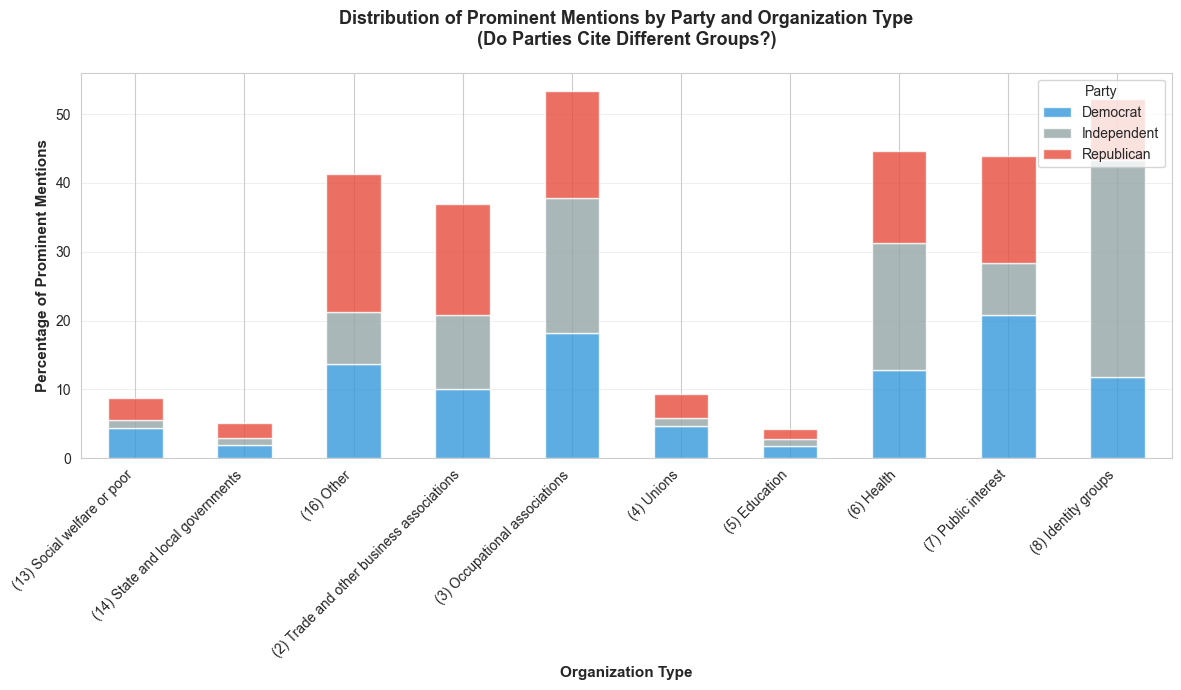

✓ Figure saved: prominence_by_party_type_stacked.png


In [10]:
# Create stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))

party_type_pct.T.plot(kind='bar', stacked=True, ax=ax, 
                      color=['#3498db', '#95a5a6', '#e74c3c'],
                      alpha=0.8)

ax.set_xlabel('Organization Type', fontsize=11, fontweight='bold')
ax.set_ylabel('Percentage of Prominent Mentions', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Prominent Mentions by Party and Organization Type\n(Do Parties Cite Different Groups?)', 
             fontsize=13, fontweight='bold', pad=20)
ax.legend(title='Party', loc='upper right', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'prominence_by_party_type_stacked.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: prominence_by_party_type_stacked.png")

### 💡 What Partisan Patterns Reveal

**Finding**: Different parties elevate different organization types, though overall citation *rates* are similar.

**Implications**:

1. **Polarized Advocacy Ecosystems**: While Democrats and Republicans invoke groups at comparable rates, they invoke *different* groups—creating parallel advocacy universes with minimal cross-cutting dialogue.

2. **Strategic Rhetorical Allies**: Interest groups function as validation mechanisms in partisan debate. Invoking a group prominently signals "the experts on our side agree with me."

3. **Rare Bipartisan Authorities**: Groups like AARP or American Legion that achieve prominence across parties are exceptional. Most organizations become associated with one ideological coalition.

**Future Research**: A network analysis mapping *which specific groups* each party elevates would reveal the structure of these parallel advocacy networks.

---

## 6. Issue Area Analysis

### Which Policy Domains Generate the Most Prominent Citations?

Do certain issue areas generate more prominent group citations than others?

In [11]:
# Policy area mapping
policy_areas_dict = {
    100: 'Macroeconomics',
    200: 'Civil Rights',
    300: 'Health',
    400: 'Agriculture',
    500: 'Labor',
    600: 'Education',
    700: 'Environment',
    800: 'Energy',
    900: 'Immigration',
    1000: 'Transportation',
    1200: 'Law and Crime',
    1300: 'Social Welfare',
    1400: 'Housing',
    1500: 'Domestic Commerce',
    1600: 'Defense',
    1700: 'Technology',
    1800: 'Foreign Trade',
    1900: 'International Affairs',
    2000: 'Government Operations',
    2100: 'Public Lands',
    2300: 'Culture'
}

# Map issue areas to names
df_issue = df.copy()
df_issue['issue_area_name'] = df_issue['level1_issue_area'].map(policy_areas_dict)

# Count prominent mentions by issue area
prominent_by_issue = df_issue[df_issue['level1_prominence'] == 1].groupby(
    'issue_area_name'
).size().sort_values(ascending=False)

print("\n📊 PROMINENT MENTIONS BY POLICY AREA")
print("="*60)
print(prominent_by_issue.head(15))
print("="*60)


📊 PROMINENT MENTIONS BY POLICY AREA
issue_area_name
Macroeconomics           1439
Government Operations     899
Defense                   723
Domestic Commerce         624
Law and Crime             624
Energy                    398
Health                    289
Education                 288
Agriculture               262
International Affairs     146
Environment               137
Public Lands               93
Housing                    77
Technology                 58
Civil Rights               57
dtype: int64


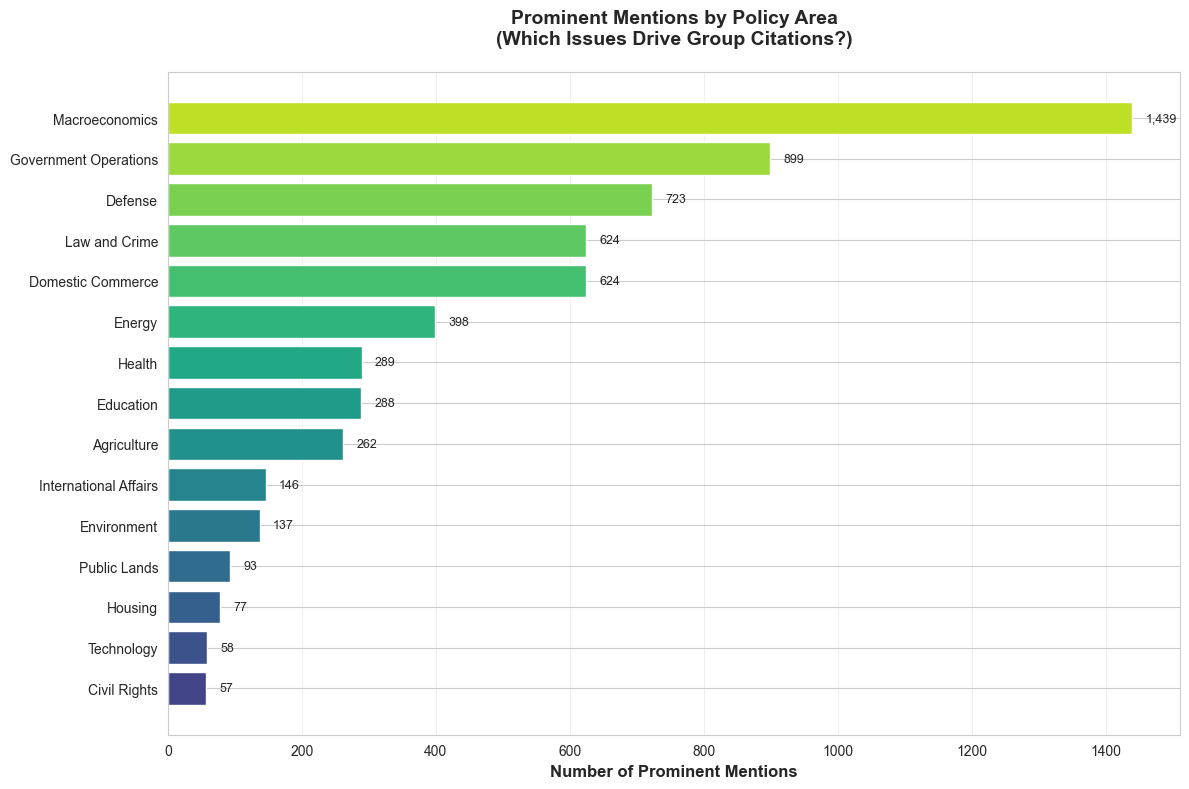

✓ Figure saved: prominence_by_issue_area.png


In [12]:
# Visualize issue area prominence
fig, ax = plt.subplots(figsize=(12, 8))

plot_data = prominent_by_issue.head(15).sort_values()

colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(plot_data)))
ax.barh(range(len(plot_data)), plot_data.values, color=colors)

ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data.index, fontsize=10)
ax.set_xlabel('Number of Prominent Mentions', fontsize=12, fontweight='bold')
ax.set_title('Prominent Mentions by Policy Area\n(Which Issues Drive Group Citations?)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, val in enumerate(plot_data.values):
    ax.text(val + 20, i, f'{int(val):,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'prominence_by_issue_area.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: prominence_by_issue_area.png")

## 7. Summary and Research Contributions

### What We Learned About Voice and Power in Democratic Discourse

This exploratory analysis demonstrates that **prominence is highly concentrated** among a small elite of advocacy organizations, with important implications for democratic representation and pluralism.

#### Key Empirical Findings

1. **Steep Hierarchy of Recognition**
   - Top 5% of organizations command 54%+ of prominent mentions
   - Power-law distribution typical of "rich-get-richer" dynamics
   - Most groups operate in relative obscurity even when mentioned

2. **Prominence ≠ Just Frequency**
   - Strong correlation (r=0.96) between mentions and prominence suggests they're related but distinct
   - 247 groups achieved 100% prominence (every mention was authoritative)
   - 749 groups never received prominence despite being mentioned

3. **Professional Expertise Confers Authority**
   - Professional associations (AMA, ABA) and membership organizations (AARP, American Legion) dominate
   - Supports "institutionalized pluralism" theory—certain traits position groups as taken-for-granted

4. **Partisan Sorting of Advocacy Recognition**
   - Democrats and Republicans cite different organization types
   - Evidence of parallel advocacy ecosystems along ideological lines
   - Suggests prominence serves coalition-building function, not just information provision

#### Theoretical Contributions

**Empirical Validation of Prominence Concept**:
- Halpin & Fraussen (2017) theorized prominence as distinct from access/influence
- This analysis provides first large-scale measurement in U.S. legislative context
- Concentration patterns confirm it's a separate dimension of interest group success

**Audience Dynamics in Legislative Communication**:
- Politicians strategically invoke groups to signal expertise and build credibility
- Partisan patterns suggest prominence serves rhetorical coalition-building
- Echoes Fenno's (1978) "home style"—members craft public positions for diverse audiences

#### Policy Implications

**For Democratic Governance**:
- Concentrated prominence raises equity concerns—are marginalized voices heard?
- Partisan sorting may exacerbate polarization in advocacy ecosystems
- Policymakers' "go-to" groups may create information echo chambers

**For Advocacy Organizations**:
- **Legitimacy, expertise, and timing** create prominence opportunities
- Membership-based organizations show advantages (constituency connection)
- New organizations face barriers but can break through (age doesn't fully determine prominence)

**For Lobbying Reform**:
- Traditional disclosure (expenditure) misses prominence pathway
- Tracking group citations in legislative debate could complement lobbying disclosure
- Resource bias in *access* may differ from bias in *voice*

---

## 8. Limitations and Future Directions

### Data Constraints

- **Congressional Record focus**: Misses private communications, committee hearings, markup sessions
- **Time period**: 2014-2018 predates recent polarization increases
- **Classification accuracy**: SVM classifier ~81% accurate (some misclassification inevitable)

### Unanswered Questions

1. **Causality**: Does prominence lead to policy outcomes? Or just correlate with pre-existing alignment?
2. **Mechanism**: What *specific language patterns* distinguish prominent from casual mentions?
3. **Temporal Dynamics**: How do prominence hierarchies shift during policy crises or elections?
4. **Cross-National**: Do similar patterns hold in parliamentary systems or state legislatures?

### Next Steps for Research

**Event Study Analysis**: Track prominence spikes around major policy debates (e.g., ACA repeal, tax reform)

**Network Visualization**: Map organization-member-policy co-occurrence patterns to reveal advocacy ecosystems

**Qualitative Validation**: Interview congressional staffers about group selection criteria for speeches

**Causal Inference**: Natural experiments (committee assignment changes, leadership transitions)

---

### Final Reflection

This analysis reveals that **democratic voice is not just about access to the table—it's about who gets quoted at the table**. Prominence represents a subtle but consequential form of power: the ability to be invoked as an authoritative voice, to have one's perspectives legitimized (or weaponized) by elected officials, and to shape the boundaries of legitimate debate.

Understanding these dynamics helps us ask better questions about pluralism, representation, and the quality of democratic deliberation.

---

## Appendix: Technical Implementation

**Reproducibility:**
- Analysis runs on `level1_FINAL.csv` (19,165 mentions)
- All figures saved to `output/figures/` directory
- Code uses relative paths—works anywhere repository is cloned

**Tools & Methods:**
- Python: pandas, numpy, matplotlib, seaborn, scipy
- Prominence classification: SVM (81% accuracy)
- Data sources: Congressional Record (GovInfo API), Washington Representatives Study

**Citation:**
```
Mazurek, K. (2023). Beyond Policy Influence: A Deeper Dive into the Factors 
Driving Advocacy Group Prominence. Master's Thesis, University of Amsterdam.
```

**Contact:** kalebmazurek@gmail.com

---

*This notebook was created as part of a portfolio showcasing research skills in political data science, computational text analysis, and democratic governance research.*